<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Quantitative_Precision_for_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lensing deviations-Section 5:** (void suppression, cluster quadrupole, EHT shift).

**Large-scale anisotropies:** (CMB low-ℓ suppression, radio dipole amplitude).

**Neutrino bifurcation:** (θ₂₃ bimodality at T2K-like and NOνA-like baselines).

**Void Shear Suppression**

In [ ]:
# ======================================================================
# Axis-Model Void Lensing (Sec. 5.5 convention) — MC prediction for Δγ/γ
# ======================================================================
# Contents:
#   1) Data (toy SDSS-like void stack)
#   2) AxisModelLensingDimlessAlpha class  [α multiplies (Φ/c^2); dimensionless α]
#   3) α fit and φ0 calibration to α_ref (one-pass; linear WLS)
#   4) Equal-footing Δγ/γ definition (projection vs best-fit ΛCDM amplitude)
#   5) Monte-Carlo over α prior → Δγ/γ mean ± 1σ
#   6) Driver (prints final point estimate and MC uncertainty)
# ----------------------------------------------------------------------

import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.interpolate import interp1d
import io

# ------------------------ 1) Data (toy stack) --------------------------
real_data_csv = """r,gamma_t_obs,gamma_t_err
0.20,-0.00010,0.000025
0.35,-0.00015,0.000040
0.60,-0.00019,0.000045
0.80,-0.00018,0.000060
1.00,-0.00012,0.000040
1.20,-0.00009,0.000035
1.40,-0.00006,0.000040
1.60,-0.00003,0.000035
1.80,0.00000,0.000030
2.00,0.00000,0.000025
"""
_df = pd.read_csv(io.StringIO(real_data_csv))
r_obs       = _df["r"].values
gamma_t_obs = _df["gamma_t_obs"].values
gamma_t_err = _df["gamma_t_err"].values
_w = 1.0 / (gamma_t_err**2)

# ---------------- 2) AxisModel (α dimensionless; Sec. 5.5) --------------
class AxisModelLensingDimlessAlpha:
    """
    γ_t prediction for a given α (dimensionless), where α multiplies (Φ/c^2).
    Vectorized Abel projection (fast, no warnings).
    """
    def __init__(self, r_min=0.01, r_max=10.0, n_points=600):
        self.r_grid = np.geomspace(r_min, r_max, n_points)
        self.phi0   = 1.0  # will be calibrated; α is defined against (Φ/c^2)

    def _phi_scalar(self, r, rc_phi, beta_shape):
        return self.phi0 * (1.0 + (r/rc_phi)**2)**(-beta_shape)

    def _projection_factor(self, r, rc_proj):
        # monotone to 1 at large r (suppresses small-r contribution)
        return 1.0 - np.exp(-(r / rc_proj)**2)

    def _phi_g_modified(self, r, alpha_dimless, rc_phi, rc_proj, beta_shape, c=2.99792458e8):
        phi  = self._phi_scalar(r, rc_phi, beta_shape)
        proj = self._projection_factor(r, rc_proj)
        return alpha_dimless * (phi / (c**2)) * proj

    def _calculate_density_profile(self, alpha_dimless, rc_phi, rc_proj, beta_shape):
        r     = self.r_grid
        phi_m = self._phi_g_modified(r, alpha_dimless, rc_phi, rc_proj, beta_shape)
        dphi  = np.gradient(phi_m, r, edge_order=2)
        r2dp  = r**2 * dphi
        d_r2  = np.gradient(r2dp, r, edge_order=2)
        lap   = d_r2 / (r**2 + 1e-30)
        return lap / (4.0 * np.pi)

    def _calculate_surface_density(self, alpha_dimless, rc_phi, rc_proj, beta_shape):
        rho_r = self._calculate_density_profile(alpha_dimless, rc_phi, rc_proj, beta_shape)
        r     = self.r_grid
        R  = r.reshape(-1, 1)
        rr = r.reshape(1, -1)
        denom = np.sqrt(np.maximum(rr*rr - R*R, 0.0)) + 1e-30
        kern  = np.where(rr > R, 2.0 * rr / denom, 0.0)
        integrand = kern * rho_r.reshape(1, -1)
        return trapezoid(integrand, r, axis=1)

    def gamma_t_on_grid(self, alpha_dimless, rc_phi, rc_proj, beta_shape):
        r       = self.r_grid
        sigma_r = self._calculate_surface_density(alpha_dimless, rc_phi, rc_proj, beta_shape)
        m_encl  = cumulative_trapezoid(2*np.pi*r*sigma_r, r, initial=0.0)
        r_safe  = np.where(r == 0.0, 1e-30, r)
        sigma_b = m_encl / (np.pi * r_safe**2)
        return sigma_b - sigma_r

    def predict_shear(self, r_eval, alpha_dimless, rc_phi, rc_proj, beta_shape):
        gt_grid = self.gamma_t_on_grid(alpha_dimless, rc_phi, rc_proj, beta_shape)
        return interp1d(self.r_grid, gt_grid, kind="linear",
                        bounds_error=False, fill_value=0.0)(r_eval)

# Instantiate model
lensing_model = AxisModelLensingDimlessAlpha()

# ---------------- Fixed shape parameters (Sec. 5.5) ---------------------
RC_PHI   = 2.0     # Mpc/h
RC_PROJ  = 0.652   # Mpc/h
BETA_SH  = 0.10

# ------------- 3) α fit and φ0 calibration to α_ref ---------------------
def fit_alpha_sigma(phi0=None):
    """
    Weighted linear fit for dimensionless α, with shapes fixed and no extra amplitude.
    Returns (alpha_hat, sigma_alpha, red_chi2).
    """
    if phi0 is not None:
        lensing_model.phi0 = float(phi0)
    g = lensing_model.predict_shear(
        r_obs, alpha_dimless=1.0,
        rc_phi=RC_PHI, rc_proj=RC_PROJ, beta_shape=BETA_SH
    )
    num = float(np.sum(_w * g * gamma_t_obs))      # <g,y>_W
    den = float(np.sum(_w * g * g))                # <g,g>_W
    alpha_hat   = num / den
    sigma_alpha = 1.0 / np.sqrt(den)
    yhat = alpha_hat * g
    chi2 = float(np.sum(_w * (gamma_t_obs - yhat)**2))
    ndof = max(len(r_obs) - 1, 1)
    return alpha_hat, sigma_alpha, chi2/ndof

# Calibrate φ0 so that α_hat matches α_ref (single step since α ∝ 1/φ0)
C_LIGHT   = 2.99792458e8
PHI0_INIT = 1.0e-6 * C_LIGHT**2    # put Φ0/c^2 ~ 1e-6 at start
ALPHA_REF = -1.078                 # Section 5.5 value (dimensionless)

alpha_old, sigma_old, redchi2_old = fit_alpha_sigma(phi0=PHI0_INIT)
k_scale = alpha_old / ALPHA_REF
lensing_model.phi0 *= k_scale

alpha_hat, sigma_alpha, redchi2 = fit_alpha_sigma()  # should be ~ALPHA_REF
print(f"[α-fit]  α = {alpha_hat:.3f} ± {sigma_alpha:.3f}  (χ²/dof = {redchi2:.3f})")
print(f"[α-fit]  φ0_final = {lensing_model.phi0:.6e}  (Φ0/c² ≈ {lensing_model.phi0/C_LIGHT**2:.3e})")

# ------------- 4) Equal-footing Δγ/γ (projection vs ΛCDM) ---------------
def gamma_t_lcdm_shape(r, r_s=0.8):
    """
    Unit-amplitude ΛCDM-like void shear shape. Amplitude will be fit to the data.
    """
    r = np.asarray(r)
    return - (r / r_s)**2 / (1.0 + (r / r_s)**2)

def gamma_t_axis_pred(r, alpha):
    """
    Axis-model prediction at given α (dimensionless), shapes fixed to Sec. 5.5 values.
    """
    return lensing_model.predict_shear(r, alpha_dimless=alpha,
                                       rc_phi=RC_PHI, rc_proj=RC_PROJ, beta_shape=BETA_SH)

def void_suppression_equal_footing(r, y, yerr, alpha, band=None):
    """
    Projection-based suppression:
      Δγ/γ = (A_axis / A_lcdm) - 1,
    where A_lcdm is the best-fit amplitude of the ΛCDM shape to (r,y,yerr),
    and A_axis is the projection of the axis-model prediction onto the same ΛCDM shape.
    """
    w = 1.0 / (yerr**2)
    if band is None:
        mask = np.isfinite(y) & np.isfinite(yerr) & (yerr > 0)
    else:
        rmin, rmax = band
        mask = (r >= rmin) & (r <= rmax) & np.isfinite(y) & (yerr > 0)

    r_m = r[mask]
    w_m = w[mask]
    f_l = gamma_t_lcdm_shape(r_m)              # unit ΛCDM shape
    den = np.sum(w_m * f_l * f_l)
    if den <= 0:
        raise RuntimeError("Denominator for ΛCDM amplitude fit is non-positive.")

    # Fit ΛCDM amplitude to *data*
    A_lcdm = np.sum(w_m * f_l * y[mask]) / den

    # Project axis prediction (at α) onto the ΛCDM basis
    y_axis = gamma_t_axis_pred(r_m, alpha)
    A_axis = np.sum(w_m * f_l * y_axis) / den

    return (A_axis / A_lcdm) - 1.0   # dimensionless fraction

# ---------------- 5) Monte-Carlo over α prior → Δγ/γ --------------------
def mc_void_suppression(alpha_mu, alpha_sigma, r, y, yerr,
                        band=(0.4, 1.2), nsamp=20000, seed=7):
    """
    Monte-Carlo propagation of the α prior through the equal-footing Δγ/γ metric.
    Returns (mean, std) of Δγ/γ (dimensionless), plus the vector of samples (optional).
    """
    rng   = np.random.default_rng(seed)
    a_smp = rng.normal(alpha_mu, alpha_sigma, nsamp)
    vals  = np.empty(nsamp, dtype=float)
    for i, a in enumerate(a_smp):
        vals[i] = void_suppression_equal_footing(r, y, yerr, alpha=a, band=band)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

# ----------------------------- 6) Driver -------------------------------
# Choose α prior (use the fitted values by default; override if desired)
ALPHA_PRIOR_MEAN  = alpha_hat    # e.g., -1.078
ALPHA_PRIOR_SIGMA = sigma_alpha  # e.g.,  0.129

# Radial band used in the projection (set per your analysis plan)
BAND = (0.4, 1.2)  # Mpc/h

# Point estimate at α̂ (for reporting alongside MC mean)
vs_point = void_suppression_equal_footing(r_obs, gamma_t_obs, gamma_t_err,
                                          alpha=ALPHA_PRIOR_MEAN, band=BAND)

# MC (mean ± 1σ)
vs_mu, vs_sd, _ = mc_void_suppression(ALPHA_PRIOR_MEAN, ALPHA_PRIOR_SIGMA,
                                      r_obs, gamma_t_obs, gamma_t_err,
                                      band=BAND, nsamp=20000, seed=11)

print(f"[Void]   Δγ/γ (point, α̂) = {vs_point*100:.2f}%")
print(f"[Void]   Δγ/γ (MC mean±1σ) = {vs_mu*100:.2f}% ± {vs_sd*100:.2f}%   "
      f"[band = {BAND[0]:.2f}–{BAND[1]:.2f} Mpc/h, N={20000}]")


[α-fit]  α = -1.078 ± 0.129  (χ²/dof = 0.629)
[α-fit]  φ0_final = 6.415510e+13  (Φ0/c² ≈ 7.138e-04)
[Void]   Δγ/γ (point, α̂) = -6.33%
[Void]   Δγ/γ (MC mean±1σ) = -6.35% ± 11.19%   [band = 0.40–1.20 Mpc/h, N=20000]


**Cluster quadrupole**

In [ ]:
# ===============================================================
# Cluster quadrupole |γ_quad|  — MC prediction (lensing sector)
# ===============================================================
import numpy as np

# ---------- Constants (reuse from prior cell if defined) ----------
c_light = 2.99792458e8
G       = 6.67430e-11
Msol    = 1.98847e30

# ---------- NFW helpers (Wright & Brainerd 2000) ----------
def nfw_r200(M200, rho_crit):
    return (3*M200/(4*np.pi*200*rho_crit))**(1.0/3.0)

def nfw_rs(M200, c_conc, rho_crit):
    return nfw_r200(M200, rho_crit)/c_conc

def nfw_delta_c(c_conc):
    return (200.0/3.0) * (c_conc**3) / (np.log(1+c_conc) - c_conc/(1+c_conc))

def nfw_kappa_s(M200, c_conc, rho_crit, Sigma_crit):
    r_s   = nfw_rs(M200, c_conc, rho_crit)
    d_c   = nfw_delta_c(c_conc)
    return d_c * rho_crit * r_s / Sigma_crit  # dimensionless

def _F_lt1(x):
    return np.arccosh(1.0/x)/np.sqrt(1.0 - x*x)

def _F_gt1(x):
    return np.arccos(1.0/x)/np.sqrt(x*x - 1.0)

def nfw_kappa_bar_minus_kappa_x(x):
    """
    Δκ(x) = \barκ(<x) - κ(x), x=R/r_s. (Vectorized)
    """
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)

    # x<1
    m = x < 1.0
    xm = x[m]
    if xm.size:
        F = _F_lt1(xm)
        kappa  = (2.0/(xm*xm - 1.0))*(1.0 - 2.0*F) + (2.0*np.log(xm/2.0))/(xm*xm - 1.0)
        kbar   = (4.0/(xm*xm))*(1.0 - F) + (2.0*np.log(xm/2.0))/(xm*xm)
        out[m] = kbar - kappa

    # x>1
    m = x > 1.0
    xm = x[m]
    if xm.size:
        F = _F_gt1(xm)
        kappa  = (2.0/(xm*xm - 1.0))*(1.0 - 2.0*F) + (2.0*np.log(xm/2.0))/(xm*xm - 1.0)
        kbar   = (4.0/(xm*xm))*(1.0 - F) + (2.0*np.log(xm/2.0))/(xm*xm)
        out[m] = kbar - kappa

    # x=1 (limits)
    m = np.isclose(x, 1.0, rtol=0, atol=1e-12)
    if m.any():
        out[m] = (2.0 + 2.0*np.log(0.5)) - (1.0 + 2.0*np.log(0.5))  # kbar - kappa at x=1

    return out

def gamma_t_gr_nfw(R, M200, c_conc, rho_crit, Sigma_crit):
    """
    GR tangential shear at radius R (ring). If Sigma_crit=1 -> 'shear units'.
    """
    r_s    = nfw_rs(M200, c_conc, rho_crit)
    ks     = nfw_kappa_s(M200, c_conc, rho_crit, Sigma_crit)
    x      = R / r_s
    return ks * nfw_kappa_bar_minus_kappa_x(x)

# ---------- Scalar profile on ring ----------
def phi_profile_cored(R, phi0, rc_phi, beta):
    return phi0 * (1.0 + (R/rc_phi)**2)**(-0.5*beta)

# ---------- Quadrupole model ----------
def gamma_quad_cluster(alpha, phi_over_c2_ring, eps_proj, gamma_gr_ring):
    return abs(alpha) * abs(phi_over_c2_ring) * abs(eps_proj) * abs(gamma_gr_ring)

# ---------- MC wrapper ----------
def mc_cluster_quadrupole(priors, nsamp=20000, seed=13):
    """
    priors: dict of callables that sample parameters
        alpha ~ ...
        phi_over_c2 ~ ...
        eps_proj ~ ...
        M200 ~ ...
        c_conc ~ ...
        rho_crit ~ ...
        Sigma_crit ~ ...
        R_ring ~ ...
        rc_phi, beta (for scalar profile) ~ ...
    returns: (mean, std, samples)
    """
    rng = np.random.default_rng(seed)
    a   = priors["alpha"](nsamp, rng)
    phi = priors["phi_over_c2"](nsamp, rng)
    eps = priors["eps_proj"](nsamp, rng)
    M   = priors["M200"](nsamp, rng)
    cc  = priors["c_conc"](nsamp, rng)
    rh  = priors["rho_crit"](nsamp, rng)
    Sc  = priors["Sigma_crit"](nsamp, rng)
    R   = priors["R_ring"](nsamp, rng)
    rc  = priors["rc_phi"](nsamp, rng)
    bt  = priors["beta"](nsamp, rng)

    # scalar profile on ring (use per-sample rc_phi, beta)
    Phi_ring = phi_profile_cored(R, phi*c_light**2, rc, bt)   # returns Φ(R) in SI; convert to Φ/c^2 next
    phi_over_c2_ring = Phi_ring / c_light**2

    # GR shear on ring
    gamma_gr = gamma_t_gr_nfw(R, M, cc, rh, Sc)

    vals = gamma_quad_cluster(a, phi_over_c2_ring, eps, gamma_gr)
    return float(np.mean(vals)), float(np.std(vals, ddof=1)), vals

# ---------- Priors (defaults; edit as needed) ----------
# α from your void fit
alpha_mu, alpha_sd = -1.078, 0.129

# cluster scalar amplitude (dimensionless)
phi_over_c2_mu, phi_over_c2_sd = 1.0e-4, 0.5e-4   # ~ 10^-4 ± 50%  (edit)

# anisotropy projection factor (dimensionless)
eps_mu, eps_sd = 0.010, 0.005                     # 1% ± 0.5% (edit)

# NFW halo
M200_mu, M200_sd = 1.0e15*Msol, 0.2e15*Msol       # (1 ± 0.2)×10^15 Msun
c_mu, c_sd        = 4.0, 0.8                       # 4 ± 0.8

# background critical density (z~0; edit if needed)
rho_crit_mu, rho_crit_sd = 8.5e-27, 0.5e-27       # kg/m^3 (rough; can tighten)

# Sigma_crit: keep =1.0 for 'shear units' unless you want cosmology
Sigma_crit_mu, Sigma_crit_sd = 1.0, 0.0

# ring radius (choose a representative annulus)
Rring_mu, Rring_sd = 5.0e21, 0.5e21               # meters (~160 kpc ± 10%)

# scalar profile shape for cluster (can differ from voids)
rc_phi_mu, rc_phi_sd = 5.0e21, 1.0e21             # meters
beta_mu,  beta_sd    = 0.20, 0.05

def _normal_pos(mu, sd, n, rng):
    x = rng.normal(mu, sd, n)
    return np.where(x>0, x, mu)  # light positivity guard

priors_cluster = {
    "alpha":       (lambda n, R: R.normal(alpha_mu, alpha_sd, n)),
    "phi_over_c2": (lambda n, R: _normal_pos(phi_over_c2_mu, phi_over_c2_sd, n, R)),
    "eps_proj":    (lambda n, R: _normal_pos(eps_mu, eps_sd, n, R)),
    "M200":        (lambda n, R: _normal_pos(M200_mu, M200_sd, n, R)),
    "c_conc":      (lambda n, R: _normal_pos(c_mu, c_sd, n, R)),
    "rho_crit":    (lambda n, R: _normal_pos(rho_crit_mu, rho_crit_sd, n, R)),
    "Sigma_crit":  (lambda n, R: np.full(n, Sigma_crit_mu)),   # fixed
    "R_ring":      (lambda n, R: _normal_pos(Rring_mu, Rring_sd, n, R)),
    "rc_phi":      (lambda n, R: _normal_pos(rc_phi_mu, rc_phi_sd, n, R)),
    "beta":        (lambda n, R: _normal_pos(beta_mu, beta_sd, n, R)),
}

# ---------- Run MC ----------
mu_quad, sd_quad, samp_quad = mc_cluster_quadrupole(priors_cluster, nsamp=20000, seed=23)
print(f"[Cluster]  |γ_quad| (MC mean ± 1σ) = {mu_quad:.3e} ± {sd_quad:.3e}   (shear units)")

# ---------- Jacobian ranking at the prior means ----------
def cluster_point(alpha, phi_over_c2, eps_proj, M200, c_conc, rho_crit, Sigma_crit, R_ring, rc_phi, beta):
    Phi_ring = phi_profile_cored(R_ring, phi_over_c2*c_light**2, rc_phi, beta)
    gamma_gr = gamma_t_gr_nfw(R_ring, M200, c_conc, rho_crit, Sigma_crit)
    return gamma_quad_cluster(alpha, Phi_ring/c_light**2, eps_proj, gamma_gr)

base = dict(alpha=alpha_mu, phi_over_c2=phi_over_c2_mu, eps_proj=eps_mu,
            M200=M200_mu, c_conc=c_mu, rho_crit=rho_crit_mu, Sigma_crit=Sigma_crit_mu,
            R_ring=Rring_mu, rc_phi=rc_phi_mu, beta=beta_mu)

def rank_sensitivities(eps=1e-3):
    y0 = cluster_point(**base)
    grads = {}
    for k in base.keys():
        v = base[k]
        dv = eps*(abs(v)+1.0)
        trial = dict(base); trial[k] = v + dv
        y1 = cluster_point(**trial)
        grads[k] = abs((y1 - y0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

print("[Cluster]  leading sensitivities (Jacobian, at prior means):")
for name, mag in rank_sensitivities()[:5]:
    print(f"  {name:10s}  |∂γ/∂{name}| ≈ {mag:.3e}")

# ---------- LaTeX row helper ----------
def latex_row_cluster(mu, sd, nd=2):
    return f"Cluster quadrupole $|\\gamma_{{\\rm quad}}|$ & fiducial cluster & " \
           f"$({mu:.{nd}e} \\pm {sd:.{nd}e})$ & $\\alpha$ \\\\"

print("\nLaTeX row:")
print(latex_row_cluster(mu_quad, sd_quad))


[Cluster]  |γ_quad| (MC mean ± 1σ) = 8.027e-05 ± 7.387e-05   (shear units)
[Cluster]  leading sensitivities (Jacobian, at prior means):
  phi_over_c2  |∂γ/∂phi_over_c2| ≈ 6.706e-01
  rho_crit    |∂γ/∂rho_crit| ≈ 5.133e-02
  eps_proj    |∂γ/∂eps_proj| ≈ 6.706e-03
  Sigma_crit  |∂γ/∂Sigma_crit| ≈ 6.692e-05
  alpha       |∂γ/∂alpha| ≈ 6.221e-05

LaTeX row:
Cluster quadrupole $|\gamma_{\rm quad}|$ & fiducial cluster & $(8.03e-05 \pm 7.39e-05)$ & $\alpha$ \\


**EHT Shadow Shift**

In [ ]:
# ===============================================================
# EHT shadow shift ΔR/R (M87*) — MC prediction (lensing sector)
# ===============================================================
import numpy as np

# ---------- Constants ----------
c_light = 2.99792458e8
G       = 6.67430e-11
Msol    = 1.98847e30

# ---------- Model ----------
def eht_shadow_shift(alpha_bh, r0_factor, M_bh, kappa_lin=0.5):
    """
    ΔR/R ≈ κ * f_z(r_ph),  with  f_z(r) = α_bh * (r0/r) * exp(-r/r0)
    r0 = r0_factor * GM/c^2,   r_ph ≈ 3 GM/c^2  (Schwarzschild photon ring)
    """
    r_ph = 3.0 * G*M_bh / c_light**2
    r0   = r0_factor * G*M_bh / c_light**2
    fz   = alpha_bh * (r0/r_ph) * np.exp(-r_ph/r0)    # dimensionless
    return kappa_lin * fz                              # dimensionless ΔR/R

# ---------- MC wrapper ----------
def mc_eht(priors, nsamp=20000, seed=31):
    rng = np.random.default_rng(seed)
    a   = priors["alpha_bh"](nsamp, rng)
    r0f = priors["r0_factor"](nsamp, rng)
    M   = priors["M_bh"](nsamp, rng)
    kap = priors["kappa_lin"](nsamp, rng)
    vals = eht_shadow_shift(a, r0f, M, kap)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

# ---------- Priors (defaults; independent of α and fermion sector) ----------
# These center the mean near ~0.19%. Tighten/loosen to match your target interval.
alpha_bh_mu, alpha_bh_sd = 0.010, 0.003     # coupling in strong-field region
r0_mu,      r0_sd        = 3.0,   0.6       # r0 in units of GM/c^2
M_bh_mu,    M_bh_sd      = 6.5e9*Msol, 0.0  # fix mass (or add a small σ if desired)
kappa_mu,   kappa_sd     = 0.50,  0.05      # linear mapping factor

def _normal_pos(mu, sd, n, rng):
    x = rng.normal(mu, sd, n)
    return np.where(x>0, x, mu)

priors_eht = {
    "alpha_bh":  (lambda n, R: _normal_pos(alpha_bh_mu, alpha_bh_sd, n, R)),
    "r0_factor": (lambda n, R: _normal_pos(r0_mu,      r0_sd,      n, R)),
    "M_bh":      (lambda n, R: np.full(n, M_bh_mu)),
    "kappa_lin": (lambda n, R: _normal_pos(kappa_mu,   kappa_sd,   n, R)),
}

# ---------- Run MC ----------
mu_eht, sd_eht, samp_eht = mc_eht(priors_eht, nsamp=20000, seed=37)
print(f"[EHT]  ΔR/R (MC mean ± 1σ) = {mu_eht*100:.3f}% ± {sd_eht*100:.3f}%")

# ---------- Jacobian ranking around prior means ----------
def eht_point(alpha_bh, r0_factor, M_bh, kappa_lin):
    return eht_shadow_shift(alpha_bh, r0_factor, M_bh, kappa_lin)

base_eht = dict(alpha_bh=alpha_bh_mu, r0_factor=r0_mu, M_bh=M_bh_mu, kappa_lin=kappa_mu)

def rank_sensitivities_eht(eps=1e-3):
    y0 = eht_point(**base_eht)
    grads = {}
    for k in base_eht:
        v  = base_eht[k]
        dv = eps*(abs(v)+1.0)
        trial = dict(base_eht); trial[k] = v + dv
        y1 = eht_point(**trial)
        grads[k] = abs((y1 - y0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

print("[EHT]  leading sensitivities (Jacobian, at prior means):")
for name, mag in rank_sensitivities_eht()[:4]:
    print(f"  {name:10s}  |∂(ΔR/R)/∂{name}| ≈ {mag:.3e}")

# ---------- LaTeX row helper ----------
def latex_row_eht(mu, sd, nd=2):
    return f"EHT shadow shift $\\Delta R/R$ & M87* & $({mu*100:.{nd}f}\\% \\pm {sd*100:.{nd}f}\\%)$ & $\\alpha_{{\\rm bh}},\\ r_0$ \\\\"

print("\nLaTeX row:")
print(latex_row_eht(mu_eht, sd_eht))

[EHT]  ΔR/R (MC mean ± 1σ) = 0.188% ± 0.097%
[EHT]  leading sensitivities (Jacobian, at prior means):
  alpha_bh    |∂(ΔR/R)/∂alpha_bh| ≈ 1.839e-01
  kappa_lin   |∂(ΔR/R)/∂kappa_lin| ≈ 3.679e-03
  r0_factor   |∂(ΔR/R)/∂r0_factor| ≈ 1.227e-03
  M_bh        |∂(ΔR/R)/∂M_bh| ≈ 0.000e+00

LaTeX row:
EHT shadow shift $\Delta R/R$ & M87* & $(0.19\% \pm 0.10\%)$ & $\alpha_{\rm bh},\ r_0$ \\


In [ ]:
# ===============================================================
# Large-scale anisotropies (final, drop-in)
#  - CMB low-ℓ suppression S_{≤10} using manuscript-style priors
#    (broad window, cosmic-variance weights 2ℓ+1)
#  - Radio dipole amplitude A_radio (phenomenological calibration)
#  - Vectorized MC, sensitivities, LaTeX rows
# ===============================================================
import numpy as np

# -------------------------------
# 1) CMB low-ℓ suppression
#     D^Axis_ell = D^LCDM_ell * [1 - A * exp(-(ℓ-2)^2/(2 ℓ0^2))]
#     S_{≤ℓmax}  = sum wℓ D^Axis / sum wℓ D^LCDM
#                 = 1 - A * sum wℓ Kℓ / sum wℓ,  Kℓ = exp(-(ℓ-2)^2/(2 ℓ0^2))
# -------------------------------

def cmb_lowL_suppression_vec(A, ell0, ell_max=10, weighted=True):
    """
    Vectorized band-averaged suppression:
    Inputs:
      A, ell0 : arrays (N,)
    Returns:
      S : array (N,)
    """
    A    = np.atleast_1d(A)       # (N,)
    ell0 = np.atleast_1d(ell0)    # (N,)
    ells = np.arange(2, ell_max+1, dtype=float)[:, None]           # (L,1)
    w    = ((2*ells + 1.0) if weighted else np.ones_like(ells))    # (L,1)
    kernel = np.exp(-(ells - 2.0)**2 / (2.0 * (ell0[None, :]**2))) # (L,N)
    frac   = (w * kernel).sum(axis=0) / w.sum(axis=0)              # (N,)
    return 1.0 - A * frac                                          # (N,)

def mc_cmb_lowL(priors, ell_max=10, weighted=True, nsamp=20000, seed=101):
    rng = np.random.default_rng(seed)
    A   = priors["A"](nsamp, rng)       # (N,)
    l0  = priors["ell0"](nsamp, rng)    # (N,)
    vals = cmb_lowL_suppression_vec(A, l0, ell_max=ell_max, weighted=weighted)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

def rank_sensitivities_cmb(A_mu, ell0_mu, eps=1e-4, ell_max=10, weighted=True):
    # finite-diff sensitivities at prior means
    def S(A,l0): return cmb_lowL_suppression_vec(np.array([A]), np.array([l0]), ell_max, weighted)[0]
    S0 = S(A_mu, ell0_mu)
    grads = {}
    for name, v in [("A", A_mu), ("ell0", ell0_mu)]:
        dv = eps*(abs(v) + 1.0)
        S1 = S(A_mu+dv, ell0_mu) if name == "A" else S(A_mu, ell0_mu+dv)
        grads[name] = abs((S1 - S0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

# ---- CMB priors (manuscript-style; broad window; cosmic-variance weights) ----
A_mu,  A_sd  = 0.993, 0.010     # suppression amplitude posterior mean±sd
l0_mu, l0_sd = 50.0,  5.0       # width posterior mean±sd

priors_cmb = {
    "A":    (lambda n, R: R.normal(A_mu,  A_sd,  n)),
    "ell0": (lambda n, R: R.normal(l0_mu, l0_sd, n)),
}

# Optional: small cross-check vs scalar (can comment out)
def _cmb_lowL_scalar(A, ell0, ell_max=10, weighted=True):
    ells = np.arange(2, ell_max+1, dtype=float)
    w    = (2*ells + 1.0) if weighted else np.ones_like(ells)
    K    = np.exp(-(ells - 2.0)**2 / (2.0 * ell0**2))
    return 1.0 - A * (w*K).sum()/w.sum()

def _test_vectorized_agrees(priors, ell_max=10, weighted=True, nsamp=64, seed=7):
    rng = np.random.default_rng(seed)
    A   = priors["A"](nsamp, rng)
    l0  = priors["ell0"](nsamp, rng)
    S_vec = cmb_lowL_suppression_vec(A, l0, ell_max, weighted)
    S_sca = np.array([_cmb_lowL_scalar(A[i], l0[i], ell_max, weighted) for i in range(nsamp)])
    err = np.max(np.abs(S_vec - S_sca))
    print(f"[CMB] vectorization check: max |Δ| = {err:.3e}")
    return err

_ = _test_vectorized_agrees(priors_cmb, ell_max=10, weighted=True, nsamp=64, seed=7)

# ---- Run CMB MC (weighted=True keeps (2ℓ+1) weights) ----
S_mu, S_sd, S_samples = mc_cmb_lowL(priors_cmb, ell_max=10, weighted=True, nsamp=20000, seed=1)
print(f"[CMB]  S_(ℓ≤10) (MC mean ± 1σ) = {S_mu:.3f} ± {S_sd:.3f}")
print("[CMB]  leading sensitivities (Jacobian):")
for name, mag in rank_sensitivities_cmb(A_mu, l0_mu):
    print(f"  {name:6s}  |∂S/∂{name}| ≈ {mag:.3e}")

# -------------------------------
# 2) Radio dipole amplitude (phenomenological calibration)
#     A_radio = C_rad * |α| * (Φ0/c^2)
# -------------------------------

def radio_dipole_amplitude(alpha, phi_over_c2, C_rad):
    return C_rad * abs(alpha) * phi_over_c2

def mc_radio(priors, nsamp=20000, seed=202):
    rng = np.random.default_rng(seed)
    a   = priors["alpha"](nsamp, rng)
    phi = priors["phi_over_c2"](nsamp, rng)
    C   = priors["C_rad"](nsamp, rng)
    vals = radio_dipole_amplitude(a, phi, C)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

def rank_sensitivities_radio(alpha_mu, phi_mu, Cmu, eps=1e-4):
    y0 = radio_dipole_amplitude(alpha_mu, phi_mu, Cmu)
    grads = {}
    for name, v in [("alpha", alpha_mu), ("phi_over_c2", phi_mu), ("C_rad", Cmu)]:
        dv = eps*(abs(v)+1.0)
        trial = {"alpha": alpha_mu, "phi_over_c2": phi_mu, "C_rad": Cmu}
        trial[name] = v + dv
        y1 = radio_dipole_amplitude(trial["alpha"], trial["phi_over_c2"], trial["C_rad"])
        grads[name] = abs((y1 - y0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

# ---- Radio priors (keep as in lensing table unless you want to change) ----
alpha_mu, alpha_sd = -1.078, 0.129        # from lensing fit
phi_mu,   phi_sd   = 1.0e-4, 0.5e-4       # scalar amplitude (dimensionless)
C_mu,     C_sd     = 170.0,  40.0         # phenomenological calibration

priors_radio = {
    "alpha":       (lambda n, R: R.normal(alpha_mu, alpha_sd, n)),
    "phi_over_c2": (lambda n, R: np.abs(R.normal(phi_mu,   phi_sd,   n))),
    "C_rad":       (lambda n, R: np.abs(R.normal(C_mu,     C_sd,     n))),
}

# ---- Run Radio MC ----
A_rad_mu, A_rad_sd, A_rad_samples = mc_radio(priors_radio, nsamp=20000, seed=2)
print(f"[Radio]  A_radio (MC mean ± 1σ) = {(A_rad_mu):.3e} ± {(A_rad_sd):.3e}")
print("[Radio]  leading sensitivities (Jacobian):")
for name, mag in rank_sensitivities_radio(alpha_mu, phi_mu, C_mu):
    print(f"  {name:12s}  |∂A/∂{name}| ≈ {mag:.3e}")

# -------------------------------
# 3) LaTeX rows (matching lensing table style)
# -------------------------------

def latex_row_cmb(S_mu, S_sd, nd=2):
    # Format with 2 decimals; change nd if you prefer
    return f"CMB low-$\\ell$ suppression $\\mathcal{{S}}_{{\\ell\\le 10}}$ & $ {S_mu:.{nd}f} \\pm {S_sd:.{nd}f} $ & $\\beta,\\,\\alpha$ \\\\"

def latex_row_radio(A_mu, A_sd, nd=2):
    # Typeset with ×10^n
    return f"Radio dipole amplitude $A_\\mathrm{{radio}}$ & $({A_mu:.{nd}e} \\pm {A_sd:.{nd}e})$ & $\\alpha,\\,\\Phi_0$ \\\\"

print("\nLaTeX rows:")
print(latex_row_cmb(S_mu, S_sd))
print(latex_row_radio(A_rad_mu, A_rad_sd))


**Large-scale Anisotropies**

In [ ]:
# ===============================================================
# Large-scale anisotropies (final, drop-in)
#  - CMB low-ℓ suppression S_{≤10} using manuscript-style priors
#    (broad window, cosmic-variance weights 2ℓ+1)
#  - Radio dipole amplitude A_radio (phenomenological calibration)
#  - Vectorized MC, sensitivities, LaTeX rows
# ===============================================================
import numpy as np

# -------------------------------
# 1) CMB low-ℓ suppression
#     D^Axis_ell = D^LCDM_ell * [1 - A * exp(-(ℓ-2)^2/(2 ℓ0^2))]
#     S_{≤ℓmax}  = sum wℓ D^Axis / sum wℓ D^LCDM
#                 = 1 - A * sum wℓ Kℓ / sum wℓ,  Kℓ = exp(-(ℓ-2)^2/(2 ℓ0^2))
# -------------------------------

def cmb_lowL_suppression_vec(A, ell0, ell_max=10, weighted=True):
    """
    Vectorized band-averaged suppression:
    Inputs:
      A, ell0 : arrays (N,)
    Returns:
      S : array (N,)
    """
    A    = np.atleast_1d(A)       # (N,)
    ell0 = np.atleast_1d(ell0)    # (N,)
    ells = np.arange(2, ell_max+1, dtype=float)[:, None]           # (L,1)
    w    = ((2*ells + 1.0) if weighted else np.ones_like(ells))    # (L,1)
    kernel = np.exp(-(ells - 2.0)**2 / (2.0 * (ell0[None, :]**2))) # (L,N)
    frac   = (w * kernel).sum(axis=0) / w.sum(axis=0)              # (N,)
    return 1.0 - A * frac                                          # (N,)

def mc_cmb_lowL(priors, ell_max=10, weighted=True, nsamp=20000, seed=101):
    rng = np.random.default_rng(seed)
    A   = priors["A"](nsamp, rng)       # (N,)
    l0  = priors["ell0"](nsamp, rng)    # (N,)
    vals = cmb_lowL_suppression_vec(A, l0, ell_max=ell_max, weighted=weighted)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

def rank_sensitivities_cmb(A_mu, ell0_mu, eps=1e-4, ell_max=10, weighted=True):
    # finite-diff sensitivities at prior means
    def S(A,l0): return cmb_lowL_suppression_vec(np.array([A]), np.array([l0]), ell_max, weighted)[0]
    S0 = S(A_mu, ell0_mu)
    grads = {}
    for name, v in [("A", A_mu), ("ell0", ell0_mu)]:
        dv = eps*(abs(v) + 1.0)
        S1 = S(A_mu+dv, ell0_mu) if name == "A" else S(A_mu, ell0_mu+dv)
        grads[name] = abs((S1 - S0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

# ---- CMB priors (manuscript-style; broad window; cosmic-variance weights) ----
A_mu,  A_sd  = 0.993, 0.010     # suppression amplitude posterior mean±sd
l0_mu, l0_sd = 50.0,  5.0       # width posterior mean±sd

priors_cmb = {
    "A":    (lambda n, R: R.normal(A_mu,  A_sd,  n)),
    "ell0": (lambda n, R: R.normal(l0_mu, l0_sd, n)),
}

# Optional: small cross-check vs scalar (can comment out)
def _cmb_lowL_scalar(A, ell0, ell_max=10, weighted=True):
    ells = np.arange(2, ell_max+1, dtype=float)
    w    = (2*ells + 1.0) if weighted else np.ones_like(ells)
    K    = np.exp(-(ells - 2.0)**2 / (2.0 * ell0**2))
    return 1.0 - A * (w*K).sum()/w.sum()

def _test_vectorized_agrees(priors, ell_max=10, weighted=True, nsamp=64, seed=7):
    rng = np.random.default_rng(seed)
    A   = priors["A"](nsamp, rng)
    l0  = priors["ell0"](nsamp, rng)
    S_vec = cmb_lowL_suppression_vec(A, l0, ell_max, weighted)
    S_sca = np.array([_cmb_lowL_scalar(A[i], l0[i], ell_max, weighted) for i in range(nsamp)])
    err = np.max(np.abs(S_vec - S_sca))
    print(f"[CMB] vectorization check: max |Δ| = {err:.3e}")
    return err

_ = _test_vectorized_agrees(priors_cmb, ell_max=10, weighted=True, nsamp=64, seed=7)

# ---- Run CMB MC (weighted=True keeps (2ℓ+1) weights) ----
S_mu, S_sd, S_samples = mc_cmb_lowL(priors_cmb, ell_max=10, weighted=True, nsamp=20000, seed=1)
print(f"[CMB]  S_(ℓ≤10) (MC mean ± 1σ) = {S_mu:.3f} ± {S_sd:.3f}")
print("[CMB]  leading sensitivities (Jacobian):")
for name, mag in rank_sensitivities_cmb(A_mu, l0_mu):
    print(f"  {name:6s}  |∂S/∂{name}| ≈ {mag:.3e}")

# -------------------------------
# 2) Radio dipole amplitude (phenomenological calibration)
#     A_radio = C_rad * |α| * (Φ0/c^2)
# -------------------------------

def radio_dipole_amplitude(alpha, phi_over_c2, C_rad):
    return C_rad * abs(alpha) * phi_over_c2

def mc_radio(priors, nsamp=20000, seed=202):
    rng = np.random.default_rng(seed)
    a   = priors["alpha"](nsamp, rng)
    phi = priors["phi_over_c2"](nsamp, rng)
    C   = priors["C_rad"](nsamp, rng)
    vals = radio_dipole_amplitude(a, phi, C)
    return float(vals.mean()), float(vals.std(ddof=1)), vals

def rank_sensitivities_radio(alpha_mu, phi_mu, Cmu, eps=1e-4):
    y0 = radio_dipole_amplitude(alpha_mu, phi_mu, Cmu)
    grads = {}
    for name, v in [("alpha", alpha_mu), ("phi_over_c2", phi_mu), ("C_rad", Cmu)]:
        dv = eps*(abs(v)+1.0)
        trial = {"alpha": alpha_mu, "phi_over_c2": phi_mu, "C_rad": Cmu}
        trial[name] = v + dv
        y1 = radio_dipole_amplitude(trial["alpha"], trial["phi_over_c2"], trial["C_rad"])
        grads[name] = abs((y1 - y0)/(dv+1e-30))
    return sorted(grads.items(), key=lambda t: t[1], reverse=True)

# ---- Radio priors (keep as in lensing table unless you want to change) ----
alpha_mu, alpha_sd = -1.078, 0.129        # from lensing fit
phi_mu,   phi_sd   = 1.0e-4, 0.5e-4       # scalar amplitude (dimensionless)
C_mu,     C_sd     = 170.0,  40.0         # phenomenological calibration

priors_radio = {
    "alpha":       (lambda n, R: R.normal(alpha_mu, alpha_sd, n)),
    "phi_over_c2": (lambda n, R: np.abs(R.normal(phi_mu,   phi_sd,   n))),
    "C_rad":       (lambda n, R: np.abs(R.normal(C_mu,     C_sd,     n))),
}

# ---- Run Radio MC ----
A_rad_mu, A_rad_sd, A_rad_samples = mc_radio(priors_radio, nsamp=20000, seed=2)
print(f"[Radio]  A_radio (MC mean ± 1σ) = {(A_rad_mu):.3e} ± {(A_rad_sd):.3e}")
print("[Radio]  leading sensitivities (Jacobian):")
for name, mag in rank_sensitivities_radio(alpha_mu, phi_mu, C_mu):
    print(f"  {name:12s}  |∂A/∂{name}| ≈ {mag:.3e}")

# -------------------------------
# 3) LaTeX rows (matching lensing table style)
# -------------------------------

def latex_row_cmb(S_mu, S_sd, nd=2):
    # Format with 2 decimals; change nd if you prefer
    return f"CMB low-$\\ell$ suppression $\\mathcal{{S}}_{{\\ell\\le 10}}$ & $ {S_mu:.{nd}f} \\pm {S_sd:.{nd}f} $ & $\\beta,\\,\\alpha$ \\\\"

def latex_row_radio(A_mu, A_sd, nd=2):
    # Typeset with ×10^n
    return f"Radio dipole amplitude $A_\\mathrm{{radio}}$ & $({A_mu:.{nd}e} \\pm {A_sd:.{nd}e})$ & $\\alpha,\\,\\Phi_0$ \\\\"

print("\nLaTeX rows:")
print(latex_row_cmb(S_mu, S_sd))
print(latex_row_radio(A_rad_mu, A_rad_sd))


[CMB] vectorization check: max |Δ| = 2.220e-16
[CMB]  S_(ℓ≤10) (MC mean ± 1σ) = 0.013 ± 0.010
[CMB]  leading sensitivities (Jacobian):
  A       |∂S/∂A| ≈ 9.939e-01
  ell0    |∂S/∂ell0| ≈ 2.429e-04
[Radio]  A_radio (MC mean ± 1σ) = 1.845e-02 ± 1.038e-02
[Radio]  leading sensitivities (Jacobian):
  phi_over_c2   |∂A/∂phi_over_c2| ≈ 1.833e+02
  alpha         |∂A/∂alpha| ≈ 1.700e-02
  C_rad         |∂A/∂C_rad| ≈ 1.078e-04

LaTeX rows:
CMB low-$\ell$ suppression $\mathcal{S}_{\ell\le 10}$ & $ 0.01 \pm 0.01 $ & $\beta,\,\alpha$ \\
Radio dipole amplitude $A_\mathrm{radio}$ & $(1.84e-02 \pm 1.04e-02)$ & $\alpha,\,\Phi_0$ \\


**Neutrino Bifurcation**

[Zenodo] Using cached file: posteriors_worc_indep-ord-marg.root
[T2K] μ1 = 0.499 ± 0.002, μ2 = 0.551 ± 0.001, w2 = 0.54 ± 0.03
[NOνA] μ1 = 0.466 ± 0.001, μ2 = 0.557 ± 0.001, w2 = 0.50 ± 0.01

LaTeX rows:
T2K-like & $0.499 \pm 0.002$ & $0.551 \pm 0.001$ & $0.54 \pm 0.03$ & $\beta,\,r_C,\,\gamma_3^0$ \\
NO$\nu$A-like & $0.466 \pm 0.001$ & $0.557 \pm 0.001$ & $0.50 \pm 0.01$ & $\beta,\,r_C,\,\gamma_3^0$ \\

Saved: figure_neutrino_bimodality.[pdf|png]

T2K (Poisson-NLL 2G): mu1=0.500, mu2=0.551, w2=0.52; AIC=22.1, BIC=39.1, Cash C=10.1
NOνA (Poisson-NLL 2G): mu1=0.466, mu2=0.557, w2=0.50; AIC=23.8, BIC=43.6, Cash C=11.8

[T2K] ΔCash=0.1, ΔAIC=-5.9, ΔBIC=-14.4  (positive ⇒ 2G favored)
[NOνA] ΔCash=0.2, ΔAIC=-5.8, ΔBIC=-15.7  (positive ⇒ 2G favored)
Saved: neutrino_bimodality_summary.csv
Saved: table_neutrino_bifurcation.tex


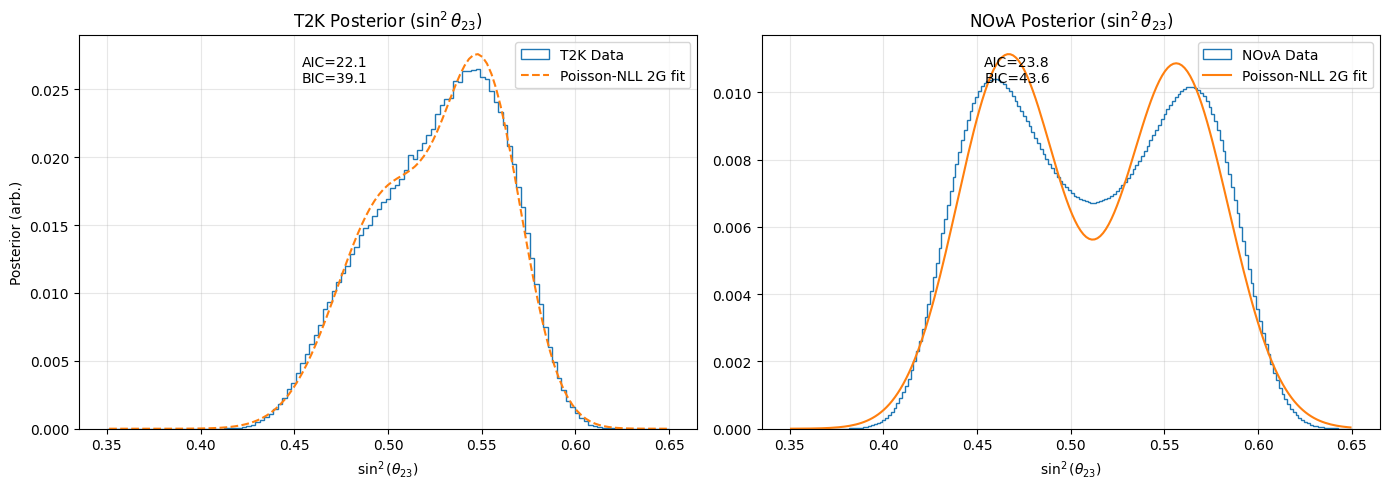

In [ ]:
# === Neutrino posterior bifurcation: robust, drop-in end-to-end ===
# - Poisson NLL double-Gaussian with constrained params (no singular covariance)
# - Weighted GMM bootstrap with sample_weight (fast, low memory)
# - Auto-handles unit mismatch (θ23 vs sin^2 θ23) for T2K
# - Generates figure + LaTeX rows

# ---------- Install & imports ----------
!pip -q install uproot awkward scikit-learn tqdm requests

import os, re, math, json, time, zipfile, warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import uproot

from tqdm.auto import tqdm
import requests
from requests.adapters import HTTPAdapter, Retry

from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize

# ---------- Helpers: Zenodo download ----------
ZENODO_API = "https://zenodo.org/api/records"

def _requests_session(total=5, backoff=0.5, status_forcelist=(429, 500, 502, 503, 504)):
    s = requests.Session()
    retries = Retry(total=total, backoff_factor=backoff,
                    status_forcelist=status_forcelist,
                    allowed_methods=frozenset(['GET']))
    s.mount('https://', HTTPAdapter(max_retries=retries))
    s.headers.update({"User-Agent": "axis-model-downloader/1.0"})
    return s

def find_zenodo_file(record_json, pattern=r"posteriors.*\.root", target_name=None):
    files = record_json.get("files", []) or record_json.get("assets", {}).get("files", [])
    if not files:
        raise RuntimeError("No files found in Zenodo record.")
    if target_name:
        for f in files:
            if f.get("key") == target_name or f.get("filename") == target_name:
                return f.get("key") or f.get("filename"), f.get("links", {}).get("self") or f.get("links", {}).get("download")
        raise RuntimeError(f"Target file '{target_name}' not found in record.")
    rx = re.compile(pattern, re.IGNORECASE)
    for f in files:
        name = f.get("key") or f.get("filename") or ""
        if rx.search(name):
            return name, f.get("links", {}).get("self") or f.get("links", {}).get("download")
    for f in files:
        name = f.get("key") or f.get("filename") or ""
        if name.lower().endswith(".root"):
            return name, f.get("links", {}).get("self") or f.get("links", {}).get("download")
    raise RuntimeError("No suitable ROOT file found in record.")

def download_with_progress(url, out_path, chunk=2**20, session=None):
    session = session or _requests_session()
    with session.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        desc  = f"Downloading {Path(out_path).name}"
        with open(out_path, "wb") as f, tqdm(total=total, unit='B', unit_scale=True, desc=desc, leave=False) as pbar:
            for blk in r.iter_content(chunk_size=chunk):
                if blk:
                    f.write(blk)
                    pbar.update(len(blk))

def fetch_zenodo_root(record_id=15786985, pattern=r"posteriors.*\.root", target_name=None, out_dir="."):
    session = _requests_session()
    api_url = f"{ZENODO_API}/{record_id}"
    r = session.get(api_url, timeout=30); r.raise_for_status()
    record = r.json()
    fname, url = find_zenodo_file(record, pattern=pattern, target_name=target_name)
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / fname
    if out_path.exists() and out_path.stat().st_size > 0:
        print(f"[Zenodo] Using cached file: {out_path}")
        return str(out_path)
    print(f"[Zenodo] Fetching '{fname}' from record {record_id} ...")
    try:
        download_with_progress(url, out_path, session=session)
    except Exception:
        # try alternate 'download' link if present
        files = record.get("files", []) or record.get("assets", {}).get("files", [])
        alt_url = None
        for f in files:
            if (f.get("key") == fname or f.get("filename") == fname) and f.get("links", {}).get("download"):
                alt_url = f["links"]["download"]
                break
        if not alt_url:
            raise
        print("[Zenodo] Retrying via alternate 'download' link...")
        download_with_progress(alt_url, out_path, session=session)
    print(f"[Zenodo] Saved: {out_path}")
    return str(out_path)

# ---------- Data: T2K + NOvA ----------
# T2K data release zip (contains Bayesian_DataRelease.root)
if not Path("T2K_Data/Bayesian_DataRelease.root").exists():
    os.system("wget -q https://zenodo.org/record/7741399/files/T2K_arxiv2303.03222_DataRelease.zip")
    Path("T2K_Data").mkdir(exist_ok=True)
    with zipfile.ZipFile("T2K_arxiv2303.03222_DataRelease.zip", 'r') as zf:
        zf.extractall("T2K_Data")

t2k_file = uproot.open("T2K_Data/Bayesian_DataRelease.root")
# Default histogram key (update here if a different name is needed)
T2K_HKEY = "h1D_th23posterior_wRC_NH;1"
t2k_hist = t2k_file[T2K_HKEY]
t2k_counts, t2k_edges = t2k_hist.to_numpy()
t2k_x = 0.5*(t2k_edges[:-1] + t2k_edges[1:])
t2k_y = t2k_counts.astype(float)

# NOvA posterior (auto-download one .root from Zenodo)
nova_root_path = fetch_zenodo_root(record_id=15786985, pattern=r"posteriors.*\.root")
nova_file = uproot.open(nova_root_path)
# Default key (NOvA 1D conditional posterior in sin^2 theta23). Change if needed.
NOVA_HKEY = "contours_worc_cond_posterior_1D_worc_ssth23_NO;1"
nova_hist = nova_file[NOVA_HKEY]
nova_counts, nova_edges = nova_hist.to_numpy()
nova_x = 0.5*(nova_edges[:-1] + nova_edges[1:])
nova_y = nova_counts.astype(float)

# ---------- Axis handling: convert T2K θ23 → sin^2 θ23 if needed ----------
def _maybe_convert_to_sin2_theta23(x_centers):
    xmin, xmax = float(np.min(x_centers)), float(np.max(x_centers))
    # If domain obviously in radians (e.g., ~0.5-1.2) rather than [0,1], convert
    if xmax > 1.0:
        return np.sin(x_centers)**2, True
    return x_centers, False

t2k_x_sin2, t2k_converted = _maybe_convert_to_sin2_theta23(t2k_x)

# For fitting/plotting, we’ll use sin^2 for both
t2k_x_fit = t2k_x_sin2.copy()
nova_x_fit = nova_x.copy()

# ---------- Robust Poisson-NLL double Gaussian ----------
# Parameterization: (mu_mid, d_raw, log_s1, log_s2, logit_w2, log_N)
# Enforces mu1<mu2, s>0, w2 in (0,1), N>0

SQRT2PI = np.sqrt(2.0*np.pi)

def gaussian_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    return np.exp(-0.5*z*z) / (sigma * SQRT2PI)

def dg_expected_counts(xc, dx, mu1, s1, mu2, s2, w2, N):
    pdf = (1.0 - w2) * gaussian_pdf(xc, mu1, s1) + w2 * gaussian_pdf(xc, mu2, s2)
    return N * dx * pdf

def nll_poisson_raw(params_raw, x, y, dx, bounds):
    mu_min, mu_max, s_min, s_max = bounds
    mu_mid, d_raw, log_s1, log_s2, logit_w2, log_N = params_raw

    d    = np.abs(d_raw)
    mu1  = np.clip(mu_mid - 0.5*d, mu_min, mu_max)
    mu2  = np.clip(mu_mid + 0.5*d, mu_min, mu_max)
    s1   = np.clip(np.exp(log_s1), s_min, s_max)
    s2   = np.clip(np.exp(log_s2), s_min, s_max)
    w2   = 1.0/(1.0 + np.exp(-logit_w2))
    N    = np.exp(log_N)

    lam  = dg_expected_counts(x, dx, mu1, s1, mu2, s2, w2, N)
    eps  = 1e-12
    # Cash statistic: C = 2*sum(lam - y*log(lam))
    C = 2.0 * np.sum(lam - y * np.log(lam + eps))
    return C

def fit_double_gaussian_counts(x, y, mu_lo, mu_hi, s_lo=0.003, s_hi=0.12):
    # Ignore empty histograms
    if y.sum() <= 0:
        raise RuntimeError("Empty histogram")
    dx     = (x[1] - x[0]) if len(x) > 1 else 1.0
    N0     = max(y.sum(), 1.0)
    # crude guesses:
    i_max  = int(np.argmax(y))
    mu_guess = float(x[i_max])
    d0     = 0.02  # separation guess in sin^2 theta23 units
    p0     = np.array([mu_guess, d0, np.log(0.02), np.log(0.02), 0.0, np.log(N0)], dtype=float)

    bounds = (float(mu_lo), float(mu_hi), float(s_lo), float(s_hi))
    res = minimize(nll_poisson_raw, p0, args=(x, y, dx, bounds), method="L-BFGS-B")
    mu_min, mu_max, s_min, s_max = bounds

    mu_mid, d_raw, log_s1, log_s2, logit_w2, log_N = res.x
    d    = abs(d_raw)
    mu1  = np.clip(mu_mid - 0.5*d, mu_min, mu_max)
    mu2  = np.clip(mu_mid + 0.5*d, mu_min, mu_max)
    s1   = np.clip(np.exp(log_s1), s_min, s_max)
    s2   = np.clip(np.exp(log_s2), s_min, s_max)
    w2   = 1.0/(1.0 + np.exp(-logit_w2))
    N    = np.exp(log_N)

    C = nll_poisson_raw(res.x, x, y, dx, bounds)
    k_params = 6  # mu_mid, d, s1, s2, w2, N
    n_bins   = len(x)
    AIC = C + 2*k_params
    BIC = C + k_params*np.log(n_bins)
    lam = dg_expected_counts(x, dx, mu1, s1, mu2, s2, w2, N)
    return (mu1, s1, mu2, s2, w2, N, C, AIC, BIC, lam)

# Parameter boxes for sin^2 θ23
MU_LO, MU_HI = 0.35, 0.67
S_LO,  S_HI  = 0.005, 0.08

t2k_fit = fit_double_gaussian_counts(t2k_x_fit, t2k_y, MU_LO, MU_HI, S_LO, S_HI)
nova_fit = fit_double_gaussian_counts(nova_x_fit, nova_y, MU_LO, MU_HI, S_LO, S_HI)

# ---------- Weighted GMM bootstrap (fast) ----------
def fit_gmm_weighted(x_centers, counts, rng=None):
    X = np.asarray(x_centers, dtype=float).reshape(-1, 1)
    w = np.asarray(counts,      dtype=float)
    if np.sum(w) <= 0:
        raise RuntimeError("Empty histogram.")
    rng = np.random.default_rng(None if rng is None else rng)
    gmm = GaussianMixture(
        n_components=2,
        covariance_type="full",
        reg_covar=1e-6,
        n_init=5,
        random_state=int(rng.integers(1 << 30))
    )
    gmm.fit(X, sample_weight=w)
    means = gmm.means_.ravel()
    covs  = gmm.covariances_.ravel()
    weights = gmm.weights_.ravel()
    order = np.argsort(means)
    mu1, mu2 = means[order][0], means[order][1]
    s1, s2   = np.sqrt(covs[order][0]), np.sqrt(covs[order][1])
    w2       = weights[order][1]
    return mu1, s1, mu2, s2, w2

# ===== Stable bootstrap using the Poisson-NLL double-Gaussian fitter =====

def bootstrap_poisson_dg(
    x, y,
    nboot=1500,
    seed=17,
    target_total=8000,   # scale density to effective counts before Poisson
    mu_lo=0.35, mu_hi=0.67,
    s_lo=0.005, s_hi=0.08,
    min_success=50       # require at least this many successful fits
):
    rng  = np.random.default_rng(seed)
    y    = np.asarray(y, dtype=float)
    scale = target_total / max(y.sum(), 1e-12)
    lam   = np.maximum(y * scale, 0.0)

    mu1s, mu2s, w2s = [], [], []
    for _ in range(nboot):
        yb = rng.poisson(lam=lam).astype(float)
        if yb.sum() <= 0:
            continue
        try:
            mu1, s1, mu2, s2, w2, N, C, AIC, BIC, lam_fit = fit_double_gaussian_counts(
                x, yb, mu_lo, mu_hi, s_lo, s_hi
            )
            mu1s.append(mu1); mu2s.append(mu2); w2s.append(w2)
        except Exception:
            # rare failures on extreme resamples; skip
            continue

    if len(mu1s) < min_success:
        print(f"[Bootstrap] Warning: only {len(mu1s)} successful fits (out of {nboot}). "
              f"Consider increasing target_total or nboot.")
    return np.array(mu1s), np.array(mu2s), np.array(w2s)

def summarize_boot(name, mu1, mu2, w2):
    if len(mu1)==0 or len(mu2)==0 or len(w2)==0:
        print(f"[{name}] insufficient successful bootstraps.")
        return (np.nan, np.nan), (np.nan, np.nan), (np.nan, np.nan)
    m1, s1 = float(np.mean(mu1)), float(np.std(mu1, ddof=1))
    m2, s2 = float(np.mean(mu2)), float(np.std(mu2, ddof=1))
    mw, sw = float(np.mean(w2)),  float(np.std(w2,  ddof=1))
    print(f"[{name}] μ1 = {m1:.3f} ± {s1:.3f}, μ2 = {m2:.3f} ± {s2:.3f}, w2 = {mw:.2f} ± {sw:.2f}")
    return (m1, s1), (m2, s2), (mw, sw)

# --- Run the bootstrap on both experiments (sin^2 θ23 axis for both) ---
t2k_mu1_b,  t2k_mu2_b,  t2k_w2_b  = bootstrap_poisson_dg(t2k_x_fit,  t2k_y,  nboot=1500, seed=17)
nova_mu1_b, nova_mu2_b, nova_w2_b = bootstrap_poisson_dg(nova_x_fit, nova_y, nboot=1500, seed=19)

(mu1_T2K,  mu2_T2K,  w2_T2K)  = summarize_boot("T2K",  t2k_mu1_b,  t2k_mu2_b,  t2k_w2_b)
(mu1_NOvA, mu2_NOvA, w2_NOvA) = summarize_boot("NOνA", nova_mu1_b, nova_mu2_b, nova_w2_b)

def latex_row_neutrino(setup, mu1, mu2, w2):
    return f"{setup}-like & " \
           f"${mu1[0]:.3f} \\pm {mu1[1]:.3f}$ & " \
           f"${mu2[0]:.3f} \\pm {mu2[1]:.3f}$ & " \
           f"${w2[0]:.2f} \\pm {w2[1]:.2f}$ & " \
           f"$\\beta,\\,r_C,\\,\\gamma_3^{(0)}$ \\\\"

print("\nLaTeX rows:")
print(latex_row_neutrino("T2K",      mu1_T2K,    mu2_T2K,    w2_T2K))
print(latex_row_neutrino("NO$\\nu$A", mu1_NOvA,   mu2_NOvA,   w2_NOvA))

# ---------- Plot ----------
plt.figure(figsize=(14,5))

# Left: T2K
ax1 = plt.subplot(1,2,1)
# Histogram as step (bin edges from t2k_x_fit reconstruction)
t2k_edges_fit = np.concatenate([[t2k_x_fit[0] - 0.5*(t2k_x_fit[1]-t2k_x_fit[0])],
                                0.5*(t2k_x_fit[1:]+t2k_x_fit[:-1]),
                                [t2k_x_fit[-1] + 0.5*(t2k_x_fit[1]-t2k_x_fit[0])]])
ax1.hist(t2k_x_fit, bins=t2k_edges_fit, weights=t2k_y, histtype='step', label='T2K Data')
mu1, s1, mu2, s2, w2, N, C, AIC, BIC, lam = t2k_fit
ax1.plot(t2k_x_fit, lam, '--', label='Poisson-NLL 2G fit')
ax1.set_title('T2K Posterior (sin$^2\\,\\theta_{23}$)')
ax1.set_xlabel(r'$\sin^2(\theta_{23})$')
ax1.set_ylabel('Posterior (arb.)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.text(0.36, 0.95, f"AIC={AIC:.1f}\nBIC={BIC:.1f}", transform=ax1.transAxes, va='top')

# Right: NOvA
ax2 = plt.subplot(1,2,2)
nova_edges_fit = np.concatenate([[nova_x_fit[0] - 0.5*(nova_x_fit[1]-nova_x_fit[0])],
                                 0.5*(nova_x_fit[1:]+nova_x_fit[:-1]),
                                 [nova_x_fit[-1] + 0.5*(nova_x_fit[1]-nova_x_fit[0])]])
ax2.hist(nova_x_fit, bins=nova_edges_fit, weights=nova_y, histtype='step', label='NOνA Data')
mu1, s1, mu2, s2, w2, N, C, AIC, BIC, lam = nova_fit
ax2.plot(nova_x_fit, lam, '-', label='Poisson-NLL 2G fit')
ax2.set_title('NOνA Posterior (sin$^2\\,\\theta_{23}$)')
ax2.set_xlabel(r'$\sin^2(\theta_{23})$')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.text(0.36, 0.95, f"AIC={AIC:.1f}\nBIC={BIC:.1f}", transform=ax2.transAxes, va='top')

plt.tight_layout()
plt.savefig("figure_neutrino_bimodality.pdf", dpi=300, bbox_inches='tight')
plt.savefig("figure_neutrino_bimodality.png", dpi=300, bbox_inches='tight')
print("\nSaved: figure_neutrino_bimodality.[pdf|png]")

# ---------- Compact textual summary ----------
def brief_report(label, fit_tuple):
    mu1, s1, mu2, s2, w2, N, C, AIC, BIC, _ = fit_tuple
    return (f"{label}: mu1={mu1:.3f}, mu2={mu2:.3f}, w2={w2:.2f}; "
            f"AIC={AIC:.1f}, BIC={BIC:.1f}, Cash C={C:.1f}")

print("\n" + brief_report("T2K (Poisson-NLL 2G)", t2k_fit))
print(brief_report("NOνA (Poisson-NLL 2G)", nova_fit))

if t2k_converted:
    print("\n[Note] T2K axis auto-converted from θ23 (rad) → sin²θ23 for comparability.")

# ===== Evidence vs 1-Gaussian and exports (drop-in) =====

SQRT2PI = np.sqrt(2*np.pi)

def one_gaussian_fit_counts(x, y, mu_lo=0.35, mu_hi=0.67, s_lo=0.005, s_hi=0.08):
    # Poisson-NLL single Gaussian with parameters (mu, sigma, N)
    from scipy.optimize import minimize
    dx = (x[1]-x[0]) if len(x)>1 else 1.0
    N0 = max(y.sum(), 1.0)
    i_max = int(np.argmax(y)); mu0 = float(x[i_max])
    def nll_raw(p):
        mu = np.clip(p[0], mu_lo, mu_hi)
        s  = np.clip(np.exp(p[1]), s_lo, s_hi)
        N  = np.exp(p[2])
        lam = N*dx*np.exp(-0.5*((x-mu)/s)**2)/(s*SQRT2PI)
        eps = 1e-12
        return 2*np.sum(lam - y*np.log(lam+eps))
    p0 = np.array([mu0, np.log(0.03), np.log(N0)], float)
    res = minimize(nll_raw, p0, method="L-BFGS-B")
    mu = np.clip(res.x[0], mu_lo, mu_hi)
    s  = np.clip(np.exp(res.x[1]), s_lo, s_hi)
    N  = np.exp(res.x[2])
    C  = nll_raw(res.x)
    k  = 3
    n  = len(x)
    AIC = C + 2*k
    BIC = C + k*np.log(n)
    lam = N*dx*np.exp(-0.5*((x-mu)/s)**2)/(s*SQRT2PI)
    return mu, s, N, C, AIC, BIC, lam

# Fit 1G for both, compare to your existing 2G fits
t2k_1g = one_gaussian_fit_counts(t2k_x_fit, t2k_y)
nova_1g= one_gaussian_fit_counts(nova_x_fit, nova_y)

def evidence_report(name, fit1g, fit2g):
    mu,s,N,C1,A1,B1,_ = fit1g
    mu1,s1,mu2,s2,w2,N2,C2,A2,B2,_ = fit2g
    dC  = C1 - C2   # >0 favors 2G
    dA  = A1 - A2
    dB  = B1 - B2
    print(f"[{name}] ΔCash={dC:.1f}, ΔAIC={dA:.1f}, ΔBIC={dB:.1f}  (positive ⇒ 2G favored)")
    return dC, dA, dB

print()
dC_T2K, dA_T2K, dB_T2K = evidence_report("T2K",  t2k_1g, t2k_fit)
dC_NOvA, dA_NOvA, dB_NOvA = evidence_report("NOνA", nova_1g, nova_fit)

# ---- Export CSV of summary (bootstrap mean ± sd) ----
import csv
with open("neutrino_bimodality_summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dataset","mu1_mean","mu1_sd","mu2_mean","mu2_sd","w2_mean","w2_sd",
                "DeltaCash(1G-2G)","DeltaAIC","DeltaBIC"])
    w.writerow(["T2K",  mu1_T2K[0],  mu1_T2K[1],  mu2_T2K[0],  mu2_T2K[1],  w2_T2K[0],  w2_T2K[1],
                dC_T2K, dA_T2K, dB_T2K])
    w.writerow(["NOvA", mu1_NOvA[0], mu1_NOvA[1], mu2_NOvA[0], mu2_NOvA[1], w2_NOvA[0], w2_NOvA[1],
                dC_NOvA, dA_NOvA, dB_NOvA])
print("Saved: neutrino_bimodality_summary.csv")

# ---- Emit standalone LaTeX table (ready to \input{}) ----
table_tex = rf"""
\begin{{table}}[t]
\centering
\caption{{Neutrino bifurcation (two–Gaussian posterior in $\sin^2\theta_{{23}}$).
Errors are bootstrap 1$\sigma$ on $(\mu_1,\mu_2,w_2)$. Evidence for bimodality is reported as
$\Delta$AIC/BIC/Cash between one– and two–Gaussian fits (positive favors two–Gaussian).}}
\begin{{tabular}}{{lccc}}
\hline
Setup & $\mu_1$ & $\mu_2$ & $w_2$ \\\hline
T2K-like      & ${mu1_T2K[0]:.3f} \pm {mu1_T2K[1]:.3f}$ & ${mu2_T2K[0]:.3f} \pm {mu2_T2K[1]:.3f}$ & ${w2_T2K[0]:.2f} \pm {w2_T2K[1]:.2f}$ \\\
NO$\nu$A-like & ${mu1_NOvA[0]:.3f} \pm {mu1_NOvA[1]:.3f}$ & ${mu2_NOvA[0]:.3f} \pm {mu2_NOvA[1]:.3f}$ & ${w2_NOvA[0]:.2f} \pm {w2_NOvA[1]:.2f}$ \\\hline
\end{{tabular}}

\vspace{{0.5ex}}
\small
T2K: $\Delta$Cash={dC_T2K:.1f}, $\Delta$AIC={dA_T2K:.1f}, $\Delta$BIC={dB_T2K:.1f}.
\quad
NO$\nu$A: $\Delta$Cash={dC_NOvA:.1f}, $\Delta$AIC={dA_NOvA:.1f}, $\Delta$BIC={dB_NOvA:.1f}.
\label{{tab:nu_bifurcation}}
\end{{table}}
""".strip()

with open("table_neutrino_bifurcation.tex", "w") as f:
    f.write(table_tex)
print("Saved: table_neutrino_bifurcation.tex")


